# Let's search through Via jobs using Python and Pandas!

There are a lot of jobs available on Via's job page on [greenhouse.io](https://boards.greenhouse.io/via?gh_src=5109dfc22). But, I'm only interested in ones that consider Python or SQL as a skill (since I just completed my course at General Assembly and want to make use of my Python / ML skills!).

So, instead of clicking manually on each link, I thought that instead I could scrape the webpage and programmatically search through the posts to find exactly what I want.

### Scraping with BeautifulSoup

I'm going to use BeautifulSoup to scrape Via's job page:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re

In [3]:
url = 'https://boards.greenhouse.io/via?gh_src=5109dfc22'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')

<Response [200]>

Below, I'm going to create a list of links of all the jobs available:

In [24]:
links = []
for link in soup.find_all("a"):
    links.append('https://boards.greenhouse.io'+link.get("href"))

Let's examine the first five links:

In [29]:
links[0:5]

['https://boards.greenhouse.io/via/jobs/4133927002',
 'https://boards.greenhouse.io/via/jobs/4113020002',
 'https://boards.greenhouse.io/via/jobs/4113029002',
 'https://boards.greenhouse.io/via/jobs/4113073002',
 'https://boards.greenhouse.io/via/jobs/4113035002']

Let's examine the last five links:

In [227]:
links[::-1][0:5]

['https://boards.greenhouse.iohttp://www.greenhouse.io/privacy-policy',
 'https://boards.greenhouse.iohttp://www.greenhouse.io/',
 'https://boards.greenhouse.io/via/jobs/4113895002',
 'https://boards.greenhouse.io/via/jobs/4113896002',
 'https://boards.greenhouse.io/via/jobs/4127284002']

Got two junk links. Let's drop those.

In [228]:
del links[-2:]

In [245]:
len(links)

166

Now let's request the job title, overview, responsibilities, and qualifications for each job:

In [240]:
import time

In [ ]:
jobs = []
locations = []
contents = []
for link in links:
    res = requests.get(link, headers = {'User-agent': 'Naman'})
    soup = BeautifulSoup(res.content, 'lxml')
    jobs.append(soup.find('h1', {'class' : 'app-title'}).text)
    locations.append(soup.find('div', {'class' : 'location'}).text)
    contents.append(soup.find('div', {'id' : 'content'}).text)
    time.sleep(3)

### Insert into DataFrame

In [ ]:
df = pd.DataFrame(columns=['app-title', 'location', 'content'])

In [ ]:
df['app-title'] = jobs
df['location'] = locations
df['content'] = contents

In [ ]:
df.head()

In [ ]:
len(df.content)

Let's save this to a csv in case we need the information in the future.

In [137]:
df.to_csv('via_jobs.csv')

It seems there is a general structure to each job post. There are 3 main categories in each post:

1. Job Overview
2. Responsibilities and Duties
3. Qualifications

Let's see if we can get each of these sections into its own column in the dataframe. First, let's homogenize the content column by removing the "about Via" section seen the the beginning of some of the cells:

Let's load the CSV now, and filter by jobs only in NY:

In [2]:
df = pd.read_csv('./via_jobs.csv')

In [3]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
df = df[df['location'].str.contains("New York")]

In [5]:
df.location.unique()

array(['\n      New York (Open to Remote)\n    ',
       '\n      New York\n    ',
       '\n      Amsterdam; Berlin; Chicago; London; New York; Washington, D.C.\n    '],
      dtype=object)

In [6]:
len(df.content)

73

Great, now let's look at the resulting df:

In [7]:
df.head()

,app-title,location,content
0,Community Engagement Principal,\n New York (Open to Remote)\n,\nJob Overview\nAs Community Engagement Princi...
1,Contract Proposal Writer,\n New York\n,\nJob Overview\nVia is looking for experienced...
2,Infrastructure Innovation Strategist,\n New York\n,"\nVia is re-engineering public transit, from a..."
4,Transportation Finance Strategist,\n New York\n,"\nVia is re-engineering public transit, from a..."
5,Urban Mobility Associate,\n New York\n,"\nVia is re-engineering public transit, from a..."


Some of the cells in content have text beginning with "\nVia is re-engineering public transit, from"... this is just an overview on Via generally, not specific to each job post, so I'll remove these, and do some other general clean-up:

In [8]:
df['content_1'] = df['content'].str.replace(r'\nVia is re-engineering.*\n', r'')
df['content_1'] = df['content_1'].str.replace(r'\nJob Overview', r'Job Overview')
df['content_1'] = df['content_1'].str.replace(r'Job Overview', r'')
df['content_1'] = df['content_1'].str.replace(r'Summary:', r'')
df['content_1'] = df['content_1'].str.replace(r'\n', r'', 1)

Now that everything is cleaned up, let's split up the main sections into their own columns:

In [9]:
df['description'] = df.content_1.str.split('Responsibilities and Duties').str.get(0)

In [10]:
df['responsibilities'] = df.content_1.str.split('Responsibilities and Duties').str.get(1)

In [11]:
df['qualifications'] = df.content_1.str.split('Qualifications').str.get(1)

And check for errors:

It looks like some of the jobs didn't have the terms "Responsibilities and Duties" and "Qualifications", and it looks like those were limited to internships, recruiters, and an executive assistant. These jobs are out of scope for my search, so I won't worry about these as a result.

In [12]:
df[df.isnull().any(axis=1)]

,app-title,location,content,content_1,description,responsibilities,qualifications
36,Executive Assistant,\n New York\n,"\nVia is re-engineering public transit, from a...","As an Executive Assistant, you will be reliabl...","As an Executive Assistant, you will be reliabl...",NaN,:\n\nMust have 2-3 years of relevant experienc...
39,Junior Recruiter,\n New York\n,"\nVia is re-engineering public transit, from a...","As a Junior Recruiter, you will find and attra...","As a Junior Recruiter, you will find and attra...",NaN,:\n\n2+ years’ experience recruiting\nReliable...
40,Recruiting Coordinator,\n New York\n,"\nJob Overview\nAs Recruiting Coordinator, you...","As Recruiting Coordinator, you will serve as p...","As Recruiting Coordinator, you will serve as p...",NaN,NaN
41,Senior Recruiter,\n New York\n,"\nVia is re-engineering public transit, from a...","As a Senior Recruiter, you will find and attra...","As a Senior Recruiter, you will find and attra...",NaN,:\n\n5+ years’ recruitment experience\nReliabl...
45,Summer MBA Intern,\n Amsterdam; Berlin; Chicago; London; Ne...,\nVia and ViaVan are looking for exceptional i...,Via and ViaVan are looking for exceptional ind...,Via and ViaVan are looking for exceptional ind...,NaN,NaN
46,Summer Undergraduate Intern,\n Amsterdam; Berlin; Chicago; London; Ne...,\nVia and ViaVan are looking for exceptional i...,Via and ViaVan are looking for exceptional ind...,Via and ViaVan are looking for exceptional ind...,NaN,NaN


In [13]:
df.dropna(inplace=True)

### Search for keywords

I want to filter by positions that have one of the following terms:
- Python
- Pandas
- SQL
- Machine Learning
- Modeling
- Data

Let's try it:

In [14]:
df.drop('content_1', axis=1, inplace=True)

In [46]:
searchfor = [r'[pP]ython', r'[pP]andas', 'SQL', r'[mM]achine [lL]earning',
             r'[iI]nvestment [bB]anking', r'[pP]rivate [eE]quity']

In [16]:
df = df[df['content'].str.contains('|'.join(searchfor))].drop([8, 47, 50, 78])

In [17]:
len(df)

18

In [18]:
df[df['content'].str.contains(searchfor[0])].head()

,app-title,location,content,description,responsibilities,qualifications
7,Business Analytics Associate,\n New York\n,\nJob Overview\nAs Business Analytics Associat...,"As Business Analytics Associate, you’ll analyz...",\n\nDevelop new measurement methodologies and ...,"\n\nObsessed with data, very strong quantitati..."
9,Data Scientist,\n New York\n,"\nJob Overview\nAs Data Scientist, you’ll util...","As Data Scientist, you’ll utilize advanced qua...",\n\nAdeptly interpret and utilize mass quantit...,\n\nObsessed with data; analytical and rigorou...
79,Growth Analytics Associate,\n New York\n,"\nJob Overview\nAs Growth Analytics Associate,...","As Growth Analytics Associate, you will define...",\n\nImprove the user experience through iterat...,"\n\nObsessed with the user experience, constan..."
80,Product Growth Associate,\n New York\n,"\nJob Overview\nAs a Product Growth Associate,...","As a Product Growth Associate, you will be of ...",\n\nCoordinate global user-centric growth expe...,\n\nConsumer and customer centric: put the cus...
81,Product Growth Principal,\n New York\n,"\nVia is re-engineering public transit, from a...","As a Product Growth Principal, you will be of ...","\n\nOwn core growth KPIs (activation, conversi...",\n\nCustomer-obsessed and customer centric: pu...


### Plot it!

In [66]:
def keyword_check(num):
    # Plot the features
    x = list(df['app-title'])
    coverage = [1 if x[i] in df[df['content'].str.contains(searchfor[num])]['app-title'].values 
                else 0.01 for i in range(len(x))]

    x_pos = [i for i, _ in enumerate(x)]

    plt.figure(figsize=(8,7));

    plt.barh(x_pos, coverage, color='green')
    plt.ylabel("Job Name", fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(searchfor[num])
    plt.gca().invert_yaxis()

    plt.yticks(x_pos, x)
    plt.xticks(np.arange(2), ('Not Present', 'Present'))

    plt.show()

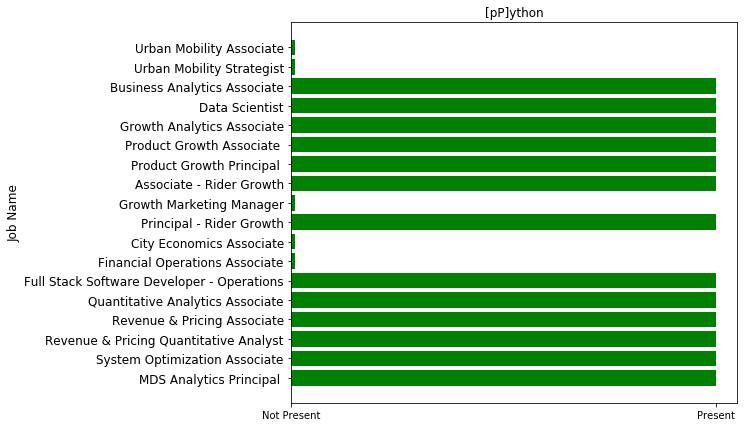

In [76]:
keyword_check(0)

### Viewing each job

From above, I know I have 18 jobs in the resulting list. In the cell below, I've defined a simple function that I can use to view each of the 18 jobs to see if it's a fit for me:

In [21]:
def view_job(job_num):
    for n in [0,1,3,4]:
        print(df.iloc[job_num][n])

In [59]:
view_job(3)

Data Scientist

      New York
    
As Data Scientist, you’ll utilize advanced quantitative & statistical analysis techniques to drive business model innovation for Via, and work closely with our senior management to help drive decisions.



Adeptly interpret and utilize mass quantities of data to generate innovative hypotheses & insights
Use sophisticated statistical methods to solve problems, leveraging up-to-date academic research and tools
Quantitatively test hypotheses about customer and driver behavior using large sets of proprietary data; leverage results to increase conversion and retention at every touch point
Design and implement novel experiments to better understand current operation as well as expansion to new markets

Qualifications

Obsessed with data; analytical and rigorous, with a thorough understanding of statistics and machine learning
Extraordinary communicator with demonstrated writing and editing skills.
Passionate about elegant visualization; you understand the 

### Final picks!

After reviewing each of the jobs above, I've narrowed my choices to the following five:

- Data Scientist
- Business Analytics Associate
- City Economics Associate
- Financial Operations Associate
- Revenue & Pricing Associate